ComputedDataV3: Include facilities (youbike, parkinglot, mrt) <br/>
ComputedDataV3: Remove facilities

In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

In [ ]:
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import torch
from utils_nn import BinaryMLP, train_neural_network, predict_nn
from utils_model import model_preprocess, print_results, get_importance

from utils import read_data, read_taiwan_specific
from config import cause_mapping, countycity_dct
from config_new import for_poly, group_translation

version = "V1"
computeddata = 'ComputedDataV3'

In [ ]:
combined_data = read_data()
# taiwan, grid_filter = read_taiwan_specific(read_grid=True)

def map_cause(cause):
    for category, causes in cause_mapping.items():
        if cause in causes:
            return category
    return "Unknown"

combined_data["cause_group"] = combined_data["肇因研判子類別名稱-主要"].apply(map_cause)

本資料夾主要完成三個模型：
- 模型1: (一維)人車路
- 模型2: (二維)人車沒有路 (加法、乘法交互) (一維有路但沒交互&一維沒有路且沒交互)
- 模型3: (三維)人車路 (加法、乘法交互)

| 需要去掉市區道路(道路類別-第1當事者-名稱)、縣市(county)這種欄位，專注在道路設計（路）、肇因（人）、車種（車）


In [ ]:
all_features_df = pd.read_csv(f"../ComputedDataV2/ForModel/all_featuresV2.csv")
all_features_df = all_features_df[all_features_df.columns[~all_features_df.columns.str.contains('道路類別-第1當事者-名稱|county|路面狀況|道路障礙|車輛撞擊部位大類別名稱|original-speed')]]
# all_features_df = all_features_df[all_features_df.columns[~all_features_df.columns.str.contains('道路類別-第1當事者-名稱|county|youbike|mrt|parkinglot')]] # for ComputedDataV4
print(all_features_df.shape)

road_features = [
    '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱',
    '車道劃分設施-分道設施-路面邊線名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱',
    '道路型態大類別名稱',
    '號誌-號誌種類名稱',
    '速限-第1當事者',
    'youbike_100m_count',
    'mrt_100m_count',
    'parkinglot_100m_count',
]
car_features = [
    '當事者區分-類別-大類別名稱-車種',
]
person_features = [
    'cause-group',
]

# This is to check if all features are in the dataframe columns
for feature in road_features + car_features + person_features:
    match_found = any(feature in col for col in all_features_df.columns)
    print(f"Checking feature: {feature}, Found: {match_found}")
    
    assert match_found, f"Feature {feature} not found in dataframe columns"

In [ ]:
defined_keywords = road_features + car_features + person_features
matched_cols = set()
for col in all_features_df.columns:
    for kw in defined_keywords:
        if kw in col:
            matched_cols.add(col)
            break

all_cols = set(all_features_df.columns)
extra_cols = all_cols - matched_cols

print(f"Dataframe 總欄位數: {len(all_cols)}")
print(f"已被關鍵字涵蓋的欄位數: {len(matched_cols)}")
print(f"額外欄位數: {len(extra_cols)}")
print("-" * 30)

if len(extra_cols) > 0:
    print("額外欄位:")
    for col in sorted(list(extra_cols)):
        print(col)
else:
    print("所有欄位都已在列表")

In [ ]:
dct_model = {
    'model_1': {
        'grid_filter': None, # None is set to not include county data
        'dim': '1way',
        'base_road': road_features,
        'base_vehicle': car_features,
        'base_person': person_features,
        'interaction_type': None,
        'model': [],
    },
    'model_2_multiply_cp': {
        'grid_filter': None,
        'dim': '2way',
        'base_road': None,
        'base_vehicle': car_features,
        'base_person': person_features,
        'interaction_type': 'multiply',
        'model': [],
    },
    'model_2_add_cp': {
        'grid_filter': None,
        'dim': '2way',
        'base_road': None,
        'base_vehicle': car_features,
        'base_person': person_features,
        'interaction_type': 'add',
        'model': [],
    },
    'model_3_multiply': {
        'grid_filter': None,
        'dim': 'mixed',
        'base_road': road_features,
        'base_vehicle': car_features,
        'base_person': person_features,
        'interaction_type': 'multiply',
        'model': [],
    },
    'model_3_add': {
        'grid_filter': None,
        'dim': 'mixed',
        'base_road': road_features,
        'base_vehicle': car_features,
        'base_person': person_features,
        'interaction_type': 'add',
        'model': [],
    },
}

In [ ]:
def model_training(
        X_train, y_train, X_resampled_test, y_resampled_test, le, model_name, set_grid_search=True
        ):
    param_grid_lr = {
        'C': [0.1, 1, 10, 100], 
        'l1_ratio': [0.1, 0.5, 0.9]
    }
    param_grid_rf = {
        'n_estimators': [100, 300],
        'max_depth': [10, 20],
        'min_samples_leaf': [1, 4]
    }

    lr_refined = LogisticRegression(
        penalty='elasticnet', solver='saga', 
        class_weight='balanced', max_iter=1000, 
        random_state=42, n_jobs=-1
        )
    rf_refined = RandomForestClassifier(
        class_weight='balanced', random_state=42, n_jobs=-1
        )

    if set_grid_search:

        grid_lr = GridSearchCV(lr_refined, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_rf = GridSearchCV(rf_refined, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

        grid_lr.fit(X_train, y_train)
        lr = grid_lr.best_estimator_
        print(f"LR best params: {lr}")
        grid_rf.fit(X_train, y_train)
        rf = grid_rf.best_estimator_
        print(f"RF best params: {rf}")

    else:
        
        lr = LogisticRegression(
            penalty='elasticnet', solver='saga', l1_ratio=0.5,
            class_weight='balanced', max_iter=1000, 
            random_state=42, 
            multi_class='multinomial',
            n_jobs=-1
        )
        rf = RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1,
            class_weight='balanced', n_jobs=-1, random_state=42,
        )
        print('logistic regression training')
        lr.fit(X_train, y_train)
        print('random forest training')
        rf.fit(X_train, y_train)

    # nn 沒有grid search
    nn_final = train_neural_network(
        X_train, y_train, le=le,
        input_dim=X_train.shape[1]
    )

    joblib.dump(lr, f'../{computeddata}/ModelPerformance/lr_model{version}_{model_name}.pkl')
    joblib.dump(rf, f'../{computeddata}/ModelPerformance/rf_model{version}_{model_name}.pkl')
    torch.save(nn_final.state_dict(), f'../{computeddata}/ModelPerformance/nn_model{version}_{model_name}.pt')
    
    proba_test_lr = lr.predict_proba(X_resampled_test)
    proba_test_rf = rf.predict_proba(X_resampled_test)
    proba_test_nn = predict_nn(nn_final, X_resampled_test)

    print_results(proba_test_lr, le.classes_, y_resampled_test)
    print_results(proba_test_rf, le.classes_, y_resampled_test)
    print_results(proba_test_nn, le.classes_, y_resampled_test)


In [ ]:
# 模型區分兩段一維、二維一組，三維一組，原因是三維資料特徵數量太高需要額外篩選，而一、二維可直接做grid search
for model_name, config in dct_model.items():
    set_grid_search = True
    print(f"training model: {model_name}")
    X_train, X_test, y_train, y_test, X_resampled_test, y_resampled_test, le = model_preprocess(
        all_features_df, 
        grid_filter=config['grid_filter'],
        dim=config['dim'],
        base_road=config['base_road'],
        base_vehicle=config['base_vehicle'],
        base_person=config['base_person'],
        interaction_type=config['interaction_type'],
    )
    if model_name == 'model_3_multiply' or model_name == 'model_3_add':
        set_grid_search = False
        print("Skip grid search for model_3 variants")
    else:
        set_grid_search = True

    model_training(
        X_train, y_train, X_resampled_test, y_resampled_test, le, model_name, set_grid_search=set_grid_search
    )

In [ ]:
def get_extracted_features(lr, rf, X_resampled_test):
    feature_order = lr.feature_names_in_
    X_sorted = X_resampled_test.reindex(columns=feature_order, fill_value=0)

    importance_lr_dict, _ = get_importance(lr, X_sorted)
    df_lr_ranked = pd.DataFrame.from_dict(importance_lr_dict, orient='index', columns=['score', 'exp_score'])
    df_lr_ranked['abs_score'] = df_lr_ranked['score'].abs()
    importance_rf_dict, _ = get_importance(rf, X_sorted)
    df_rf_ranked = pd.DataFrame.from_dict(importance_rf_dict, orient='index', columns=['score', 'exp_score'])
    df_rf_ranked['abs_score'] = df_rf_ranked['score'].abs()

    def get_dimension(feature_name):
        x_count = feature_name.count(' x ')
        if x_count == 0: return 1
        if x_count == 1: return 2 
        if x_count == 2: return 3
        return 0

    df_lr_ranked['dimension'] = df_lr_ranked.index.map(get_dimension)
    df_rf_ranked['dimension'] = df_rf_ranked.index.map(get_dimension)

    lr_dim1 = df_lr_ranked[df_lr_ranked['dimension'] == 1].index.tolist()
    lr_dim2 = df_lr_ranked[df_lr_ranked['dimension'] == 2].sort_values('abs_score', ascending=False).head(20).index.tolist()
    lr_dim3 = df_lr_ranked[df_lr_ranked['dimension'] == 3].sort_values('abs_score', ascending=False).head(20).index.tolist()
    rf_dim1 = df_rf_ranked[df_rf_ranked['dimension'] == 1].index.tolist()
    rf_dim2 = df_rf_ranked[df_rf_ranked['dimension'] == 2].sort_values('abs_score', ascending=False).head(20).index.tolist()
    rf_dim3 = df_rf_ranked[df_rf_ranked['dimension'] == 3].sort_values('abs_score', ascending=False).head(20).index.tolist()

    final_dim1 = list(set(lr_dim1 + rf_dim1))
    final_dim2 = list(set(lr_dim2 + rf_dim2))
    final_dim3 = list(set(lr_dim3 + rf_dim3))
    final_feature_list = final_dim1 + final_dim2 + final_dim3

    print(f"Original feature: {len(final_dim1)}")
    print(f"Two-way feature: {len(final_dim2)} (LR and RF union)")
    print(f"Three-way feature: {len(final_dim3)} (LR and RF union)")
    print(f"Final model feature total: {len(final_feature_list)}")

    print("top 3 way")
    print(df_lr_ranked[df_lr_ranked['dimension'] == 3].sort_values('abs_score', ascending=False).head(5).index.tolist())

    return final_feature_list


## This is for extract feature

In [ ]:
# 這裡寫法還是add, multiply各別跑
tp = 'add'
lr = joblib.load(f'../{computeddata}/ModelPerformance/lr_modelV1_model_3_{tp}.pkl')
rf = joblib.load(f'../{computeddata}/ModelPerformance/rf_modelV1_model_3_{tp}.pkl')

X_train, X_test, y_train, y_test, X_resampled_test, y_resampled_test, le = model_preprocess(
         all_features_df, grid_filter=None, dim='mixed',base_road=road_features,
         base_vehicle=car_features, base_person=person_features,interaction_type=tp)

final_feature_list = get_extracted_features(lr, rf, X_resampled_test)

X_train_refined = X_train[final_feature_list]

X_train_sorted = X_train_refined.reindex(columns=final_feature_list, fill_value=0)
X_train_resampled_reordered = X_train_sorted.reindex(columns=final_feature_list, fill_value=0)

param_grid_lr = {
    'C': [0.1, 1, 10, 100], 
    'l1_ratio': [0.1, 0.5, 0.9]
}
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 4]
}

# lr_refined = LogisticRegression(
#     penalty='elasticnet', solver='saga', 
#     class_weight='balanced', max_iter=1000, 
#     random_state=42, n_jobs=-1
# )
# rf_refined = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# grid_lr = GridSearchCV(lr_refined, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_rf = GridSearchCV(rf_refined, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# grid_lr.fit(X_train_refined, y_train)
# grid_rf.fit(X_train_refined, y_train)
print(X_train_resampled_reordered.shape)
nn_final = train_neural_network(
    X_train_resampled_reordered, y_train, le=le,
    input_dim=X_train_resampled_reordered.shape[1]
)

# best_lr_model = grid_lr.best_estimator_
# best_rf_model = grid_rf.best_estimator_
# print(f"LR best params: {grid_lr.best_params_}")
# print(f"RF best params: {grid_rf.best_params_}")

# joblib.dump(best_lr_model, f'../{computeddata}/ModelPerformance/lr_model{version}_model_3_{tp}_extracted.pkl')
# joblib.dump(best_rf_model, f'../{computeddata}/ModelPerformance/rf_model{version}_model_3_{tp}_extracted.pkl')
torch.save(nn_final.state_dict(), f'../{computeddata}/ModelPerformance/nn_model{version}_model_3_{tp}_extracted.pt')

### Load

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

file_suffix_map = {
    'model_1': 'model_1',
    'model_2_add_cp': 'model_2_add_cp',
    'model_2_multiply_cp': 'model_2_multiply_cp',
    'model_3_add': 'model_3_add_extracted',
    'model_3_multiply': 'model_3_multiply_extracted',
}

for model_name, config in dct_model.items():
    print(f"\n=== Processing: {model_name} ===")
    
    X_train, X_test, y_train, y_test, X_resampled_test, y_resampled_test, le = model_preprocess(
        all_features_df, 
        grid_filter=config['grid_filter'],
        dim=config['dim'],
        base_road=config['base_road'],
        base_vehicle=config['base_vehicle'],
        base_person=config['base_person'],
        interaction_type=config['interaction_type'],
    )

    suffix = file_suffix_map.get(model_name, model_name) 
    base_path = f'../{computeddata}/ModelPerformance'

    if model_name in ['model_3_add', 'model_3_multiply']:
        lr = joblib.load(f'../{computeddata}/ModelPerformance/lr_modelV1_{model_name}.pkl')
        rf = joblib.load(f'../{computeddata}/ModelPerformance/rf_modelV1_{model_name}.pkl')
        final_feature_list = get_extracted_features(lr, rf, X_resampled_test)    
        X_train_refined = X_train[final_feature_list]
    # X_test_refined = X_resampled_test[final_feature_list]
    try:

        lr_path = f'{base_path}/lr_modelV1_{suffix}.pkl'
        lr_model = joblib.load(lr_path)
        print(f"  -> Loaded LR: {lr_path}")

        rf_path = f'{base_path}/rf_modelV1_{suffix}.pkl'
        rf_model = joblib.load(rf_path)
        print(f"  -> Loaded RF: {rf_path}")

        if model_name in ['model_3_add', 'model_3_multiply']:
            input_dim = X_train_refined.shape[1]
            print(f"  -> Using refined input dim: {input_dim}")
        else:
            input_dim = X_train.shape[1]
            print(f"  -> Using input dim: {input_dim}")
        nn_model = BinaryMLP(in_dim=input_dim).to(device)
        nn_path = f'{base_path}/nn_modelV1_{suffix}.pt'
        nn_model.load_state_dict(torch.load(nn_path, map_location=device))
        print(f"  -> Loaded NN: {nn_path} (dim={input_dim})")

        config['model'] = [lr_model, rf_model, nn_model]

    except FileNotFoundError as e:
        print(f" [ERROR] File not found: {e}")
        continue 

In [ ]:
## Re fit for only important features
def print_results(proba_test, classes, y_resampled_test):
    """
    proba_test: 預測的概率
    classes: 類別名稱
    y_resampled_test: 重抽樣後的測試標籤
    """
    le = LabelEncoder()

    y_pred = np.argmax(proba_test, axis=1)

    print("Confusion Matrix")
    conf_matrix = confusion_matrix(y_resampled_test, y_pred, labels=range(len(classes)))
    print(conf_matrix)

    print("Classification Report")
    print(classification_report(
        y_resampled_test, y_pred, target_names=classes, digits=3
    ))

    if proba_test.shape[1] == 2:
        # 二元分類
        roc_auc = roc_auc_score(y_resampled_test, proba_test[:, 1])
        print(f'ROC AUC: {roc_auc:.3f}')
        y_test_bin = label_binarize(y_resampled_test, classes=range(len(classes)))
        pr_auc_macro  = average_precision_score(y_test_bin, proba_test[:, 1], average='macro')
        pr_auc_weight = average_precision_score(y_test_bin, proba_test[:, 1], average='weighted')
        print(f'PR  AUC macro: {pr_auc_macro:.3f}')
        print(f'PR  AUC wighted: {pr_auc_weight:.3f}')

    return conf_matrix

all_performance = {}
all_importance = {}
for model_name, config in dct_model.items():

    print(f"training model: {model_name}")
    X_train, X_test, y_train, y_test, X_resampled_test, y_resampled_test, le = model_preprocess(
        all_features_df, 
        grid_filter=config['grid_filter'],
        dim=config['dim'],
        base_road=config['base_road'],
        base_vehicle=config['base_vehicle'],
        base_person=config['base_person'],
        interaction_type=config['interaction_type'],
    )
    # don't need two reorder because they are using the same columns in training
    feature_order_lr = config['model'][0].feature_names_in_

    if model_name == 'model_3_add' or model_name == 'model_3_multiply':
        final_feature_list = get_extracted_features(config['model'][0], config['model'][1], X_resampled_test)
        X_resampled_test = X_resampled_test[final_feature_list]

    X_sorted = X_resampled_test.reindex(columns=feature_order_lr, fill_value=0)
    X_resampled_reordered = X_sorted.reindex(columns=feature_order_lr, fill_value=0)

    proba_test_lr = config['model'][0].predict_proba(X_resampled_reordered)
    proba_test_rf = config['model'][1].predict_proba(X_resampled_reordered)
    proba_test_nn = predict_nn(config['model'][2], X_resampled_reordered)
    
    # print('model performance for lr')
    # print_results(proba_test_lr, le.classes_, y_resampled_test)
    # print('model performance for rf')
    # print_results(proba_test_rf, le.classes_, y_resampled_test)

    all_performance[model_name] = {
        'lr': print_results(proba_test_lr, le.classes_, y_resampled_test),
        'rf': print_results(proba_test_rf, le.classes_, y_resampled_test),
        'nn': print_results(proba_test_nn, le.classes_, y_resampled_test),
    }

    importance_lr, importance_grouped_lr = get_importance(config['model'][0], X_resampled_reordered)
    importance_rf, importance_grouped_rf = get_importance(config['model'][1], X_resampled_reordered)

    all_importance[model_name] = {
        'lr': [importance_lr, importance_grouped_lr],
        'rf': [importance_rf, importance_grouped_rf],
    }

In [ ]:
import seaborn as sns

records = []

for model_name, algos in all_performance.items():
    for algo_name, cm in algos.items():
        tn, fp, fn, tp = cm.ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        records.append({
            'Model': model_name,
            'Algorithm': algo_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall,
        })

df = pd.DataFrame(records)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.barplot(data=df, x='Model', y='Accuracy', hue='Algorithm', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].tick_params(axis='x', rotation=15)

for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.3f')

sns.barplot(data=df, x='Model', y='F1-Score', hue='Algorithm', ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].tick_params(axis='x', rotation=15)

for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.3f')

sns.barplot(data=df, x='Model', y='Precision', hue='Algorithm', ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Model Precision Comparison')
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].tick_params(axis='x', rotation=15)

for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.3f')

sns.barplot(data=df, x='Model', y='Recall', hue='Algorithm', ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Model Recall Comparison')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].tick_params(axis='x', rotation=15)

for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()

## This is only for model with more than 2 interaction

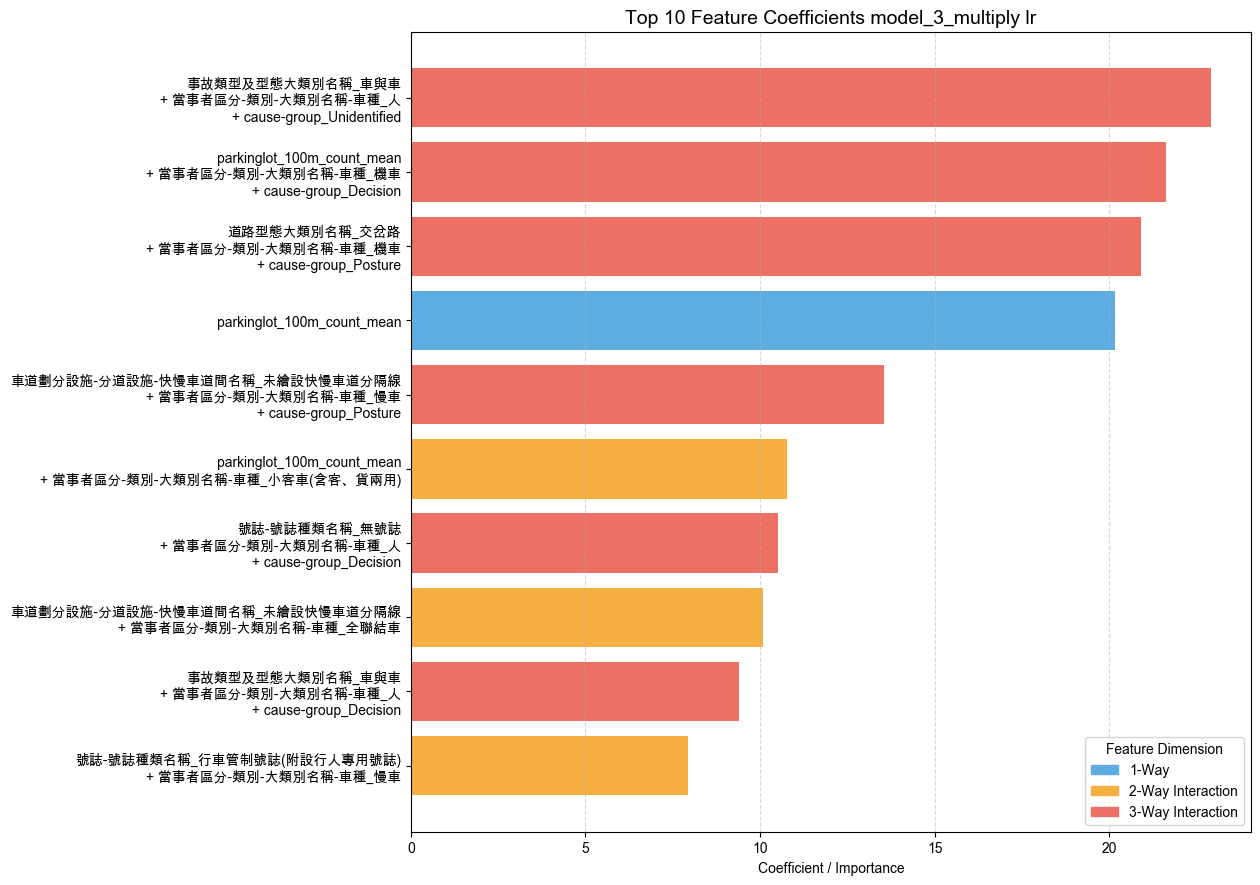

In [88]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

name = 'model_3_multiply'
model_name = 'lr'
data = all_importance[name][model_name][0]
df_importance = pd.DataFrame.from_dict(data, orient='index', columns=['Coefficient', 'Odds_Ratio'])
df_importance = df_importance.sort_values(by='Coefficient', ascending=False)
df_importance = df_importance[df_importance.index != '車道劃分設施-分道設施-路面邊線名稱_無']

df_importance_plot = df_importance.head(10).copy()
df_importance_plot = df_importance_plot.sort_values(by='Coefficient', ascending=True)
def get_dimension(feature_name):
    return feature_name.count(' x ') + 1

df_importance_plot['Dimension'] = df_importance_plot.index.map(get_dimension)

dim_colors = {1: '#5DADE2', 2: '#F5B041', 3: '#EC7063'} 
bar_colors = df_importance_plot['Dimension'].map(dim_colors)

fig, ax = plt.subplots(figsize=(12, 10))
ylabels = [label.replace(' x ', '\n + ') for label in df_importance_plot.index]

bars = ax.barh(
    range(len(df_importance_plot)), 
    df_importance_plot['Coefficient'], 
    color=bar_colors
)

ax.set_yticks(range(len(df_importance_plot)))
ax.set_yticklabels(ylabels, fontsize=10)
plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.1)

ax.set_xlabel('Coefficient / Importance')
ax.set_title(f'Top 10 Feature Coefficients {name} {model_name}', fontsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.5)

legend_handles = [
    mpatches.Patch(color=dim_colors[1], label='1-Way'),
    mpatches.Patch(color=dim_colors[2], label='2-Way Interaction'),
    mpatches.Patch(color=dim_colors[3], label='3-Way Interaction')
]
ax.legend(handles=legend_handles, loc='lower right', title="Feature Dimension")

plt.show()

In [ ]:
importance = all_importance['model_3_multiply']['lr'][0]
important_groups = []
for k, v in importance.items():
    if v[1] > 1:
        important_groups.append((k, v))

df = pd.DataFrame(important_groups, columns=['feature_name', 'scores'])
df['importance'] = df['scores'].apply(lambda x: x[0])
df['odds_ratio'] = df['scores'].apply(lambda x: x[1])

In [ ]:
def parse_interaction(row):
    parts = row.split(' x ')
    road, vehicle, person = "無", "無", "無"
    
    for p in parts:
        p_clean = p.replace('_mean', '')
        
        if 'county' in p_clean:
            # county_臺北市 -> 臺北市
            road = p_clean.split('_')[-1]
            
        # 只改POI
        elif 'count' in p_clean:
            if 'parkinglot' in p_clean: road = '停車場密度'
            elif 'youbike' in p_clean: road = 'YouBike密度'
            elif 'mrt' in p_clean: road = '捷運密度'
            else: road = p_clean

        elif '速限' in p_clean:
            road = '速限'

        # 道路
        # elif any(x in p_clean for x in ['道路', '號誌', '路面', '障礙', '事故類型']):
        #     if '_' in p_clean:
        #         road = p_clean.split('_')[-1] # 取底線後的值
        #     else:
        #         road = p_clean

        elif any(x in p_clean for x in ['道路', '號誌', '路面', '障礙', '事故類型', '車道', '設施']):
            val = p_clean.split('_')[-1] if '_' in p_clean else p_clean
            
            # "有" 或 "無" 有包含多種分向設施
            if val in ['有', '無']:
                # 找出前綴 (例如 "路面邊線名稱")
                prefix = p_clean.split('_')[0]
                # 簡化前綴 (只取最後幾個字，例如 "路面邊線")
                simple_prefix = prefix
                if '名稱' in prefix: simple_prefix = prefix.replace('名稱', '').replace('大類別', '')
                if '-' in simple_prefix: simple_prefix = simple_prefix.split('-')[-1]
                
                road = f"{val}{simple_prefix}"
            else:
                road = val

        # 車
        elif any(x in p_clean for x in ['車種', '撞擊', '當事者']):
            if '_' in p_clean:
                vehicle = p_clean.split('_')[-1]
            else:
                vehicle = p_clean

        # 人
        elif 'cause' in p_clean:
             if '_' in p_clean:
                person = p_clean.split('_')[-1]
             else:
                person = p_clean
                
    dim = len(parts)
    return pd.Series([road, vehicle, person, dim])

df[['Road', 'Vehicle', 'Person', 'Dimension']] = df['feature_name'].apply(parse_interaction)
# df = df.replace("機車", "機車與自行車")
# df = df.replace("慢車", "機車與自行車")
# '機車', '慢車', 
df = df[~df['Vehicle'].isin(['汽車', '機車與自行車'])]
df = df[~df['Road'].str[2].isin(['市', '縣'])]
df = df[~((df['Vehicle'] == '人') & (df['Road'] == '車與車'))] # 移除異常
df = df[(df['Road'] != '車與車') & (df['Road'] != '人與車')] # 雖然子類別也是道路型態，但會誤導
# df = df.head(30)

global_min = 0  
global_max = df['importance'].max()

In [ ]:
import plotly.express as px

df_3 = df[df['Dimension'] == 3].head(30)
df_plot = df_3.copy()

df_plot = df_plot.sort_values('importance', ascending=False)
fig_parcats = px.parallel_categories(
    df_plot, 
    dimensions=['Road', 'Vehicle', 'Person'],
    color="importance",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={'Road':'道路設計', 'Vehicle':'車種', 'Person':'肇因'},
    range_color=[global_min, global_max]
)

fig_parcats.update_layout(
    title="三維交互作用圖",
    height=800,
    width=1500
)

fig_parcats.show()

# 2 Way interaction

In [ ]:
def parallel_categories_plot(df_plot, dimensions_dct):
    df_plot = df_plot.sort_values('importance', ascending=False)
    fig_parcats = px.parallel_categories(
        df_plot, 
        dimensions=dimensions_dct.keys(),
        color="importance",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels=dimensions_dct,
        range_color=[global_min, global_max]
    )

    fig_parcats.update_layout(
        title="二維交互作用圖",
        height=800,
        width=1500
    )

    fig_parcats.show()

df_cause_road = df[(df['Vehicle'] == '無') & (df['Person'] != '無') & (df['Road'] != '無')].head(10).copy()
df_cause_road['Interaction'] = '人 vs 路'
df_car_road = df[(df['Vehicle'] != '無') & (df['Person'] == '無') & (df['Road'] != '無')].head(10).copy()
df_car_road['Interaction'] = '車 vs 路'
df_human_car = df[(df['Vehicle'] != '無') & (df['Person'] != '無') & (df['Road'] == '無')].head(10).copy()
df_human_car['Interaction'] = '人 vs 車'

df_combined = pd.concat([df_cause_road, df_car_road, df_human_car])

# df_combined = df_combined[df_combined['importance'] > 0.001]

df_combined = df_combined.sort_values('importance', ascending=False)

dims = ['Interaction', 'Road', 'Vehicle', 'Person']
labels_map = {'Interaction': '交互類型', 'Road':'道路設計', 'Vehicle':'車種', 'Person':'肇因'}
# dims = ['Vehicle', 'Person']
# labels_map = {'Vehicle':'車種', 'Person':'肇因'}

fig_combined = px.parallel_categories(
    df_combined, 
    dimensions=dims,
    color="importance",
    color_continuous_scale=px.colors.sequential.Inferno,
    labels=labels_map,
    range_color=[global_min, global_max]
)

fig_combined.update_layout(
    title="二維交互作用圖",
    height=900,
    width=1600
)

fig_combined.show()

In [ ]:
print(combined_data['車輛撞擊部位大類別名稱-最初'].value_counts())

In [ ]:
combined_data[(combined_data['車道劃分設施-分道設施-快車道或一般車道間名稱'] == '禁止變換車道線(無標記)') & 
              (combined_data['車輛撞擊部位大類別名稱-最初'] == '機車與自行車') &
              (combined_data['cause_group'] == 'Posture') ]

In [ ]:
col_name = '車道劃分設施-分道設施-快車道或一般車道間名稱_禁止變換車道線(無標記) x 車輛撞擊部位大類別名稱-最初_機車與自行車 x cause-group_Posture'
a = X_train_refined[[col_name]]
b = pd.concat([a, y_train], axis=1)

b[col_name] = b[col_name].apply(lambda x: '有' if x > 0 else '無')
b.value_counts()